In [ ]:
## Generate data
X, y = make_blobs(n_samples=100, centers=3, n_features=2)

In [30]:
with h5py.File('data/usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_test = test.get('target')[:]
        
        X_tr = X_tr[:2000]
        y_train = y_tr[:2000]

In [2]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets.samples_generator import make_blobs
from sklearn import svm
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy import sparse
from stop_words import get_stop_words

import itertools

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import h5py

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
cats = ['comp.sys.mac.hardware', 'comp.windows.x']
bunch1 = load_files('data/20news-bydate/20news-bydate-train', categories=cats)
bunch2 = load_files('data/20news-bydate/20news-bydate-test', categories=cats)
#print(bunch2.target)
X_train = np.array(bunch1.data)
X_test =  np.array(bunch2.data)
y_train = np.array(bunch1.target)
y_test = np.array(bunch2.target)

In [4]:
vectorizer = TfidfVectorizer(decode_error='ignore', max_features=7511, stop_words='english')
X_tr = vectorizer.fit_transform(X_train)
X_te = vectorizer.transform(X_test)

In [28]:
def transfer_func(x, kernel='linear', cut=None, t=None, n=0, i=0):
    if kernel == 'linear':
        return x
    if kernel == 'step':
        if i <= n + 10:
            return 1
        else:
            return 0
    if kernel=='poly-step':
        if i <= n + 10:
            return np.sqrt(x)
        else:
            return x**2
    if kernel == 'lin-step':
        if x >= cut:
            return x
        else:
            return 0
    if kernel == 'poly':
        return np.power(x, t)

In [20]:
## Compute RBF matrix K

def calculate_K_hat(X, kernel='linear', t=None, cut=None, number_of_points=None):

    K = rbf_kernel(X, gamma=1.65289)

    ## 1. Compute D, the diagonal matrix whose elements are the sum of the rows of K
    D = np.zeros(np.shape(K))

    for i in range(np.shape(K)[0]):
        D[i, i] = np.sum(K[i, :])

    ## 2. Compute L
    L = np.linalg.inv(np.sqrt(D)) @ K @ np.linalg.inv(np.sqrt(D))
    eigenvals, eigenvects = np.linalg.eig(L)
    Lambda = np.diag(eigenvals)
    #l = eigenvects @ Lambda @ eigenvects.T

    ## 3. Given transfer function, construct L_hat
    new_eigenvals = np.zeros(np.shape(eigenvals)) # lamdba_hat_i

    for i in range(np.shape(eigenvals)[0]):
        new_eigenvals[i] = transfer_func(eigenvals[i], kernel=kernel, t=t, cut=cut, n=number_of_points, i=i)

    lambda_hat = np.diag(new_eigenvals)
    L_hat = eigenvects @ lambda_hat @ eigenvects.T

    ## 4. Compute K_hat
    a = np.array(L_hat)
    L_hat2 = np.diag(np.diagonal(a))

    D_hat = np.linalg.inv(L_hat2)
    K_hat = np.sqrt(D_hat) @ L_hat @ np.sqrt(D_hat)

    return K_hat

In [32]:
def predict(nr_of_points, kernel_mtrx, X_test, X_train, y_train):
    start_idx = np.random.randint(np.shape(kernel_mtrx)[0] - nr_of_points)
    while True:                
        clf = svm.SVC(kernel='precomputed')
        try:      
            clf.fit(kernel_mtrx[start_idx: start_idx + nr_of_points, start_idx: start_idx + nr_of_points], y_train[start_idx: start_idx + nr_of_points])
            break
        except ValueError:
            start_idx += 1
    
    
    #kernel_test = sparse.csr_matrix.todense(np.dot(X_test, X_train[start_idx : start_idx + nr_of_points].T))
    kernel_test = np.dot(X_test, X_train[start_idx : start_idx + nr_of_points].T)
    pred = clf.predict(kernel_test)
    #print("pred:", pred)
    
    return pred
    

In [8]:
def pop_and_average(idx, li, mse):
    average = (li[idx] + mse) / 2
    li[idx] = average
    return li
        

In [13]:
def experiment(kernel, X_train, X_test, y_train, y_test, nr_of_points):

    mse = 0
    pred = predict(nr_of_points, kernel, X_test, X_train, y_train)
    mse = mean_squared_error(y_test, pred)
    
    return mse

In [21]:
def get_results(iterations):
    lin_mses = np.zeros(7)
    poly_mses = np.zeros(7)
    step_mses = np.zeros(7)
    poly_step_mses = np.zeros(7)
    mses_count = [0, 0, 0, 0, 0, 0, 0]
    nr_list = [2, 4, 8, 16, 32, 64, 128]

    count = 0
    for n in range(len(nr_list)):
        for i in range(iterations):
            nr_of_points = nr_list[n]

            K_lin = calculate_K_hat(X_tr, kernel='linear')
            K_poly = calculate_K_hat(X_tr, kernel='poly', t=5, number_of_points=nr_of_points)
            K_step = calculate_K_hat(X_tr, kernel='step', number_of_points=nr_of_points)
            K_poly_step = calculate_K_hat(X_tr, kernel='poly-step', number_of_points=nr_of_points)

            lin_mse = experiment(K_lin, X_tr, X_te, y_train, y_test, nr_of_points)
            step_mse = experiment(K_step, X_tr, X_te, y_train, y_test, nr_of_points)
            poly_mse = experiment(K_poly, X_tr, X_te, y_train, y_test, nr_of_points)
            poly_step_mse = experiment(K_poly_step, X_tr, X_te, y_train, y_test, nr_of_points)

            lin_mses[count] = lin_mses[count] + lin_mse
            poly_mses[count] = poly_mses[count] + poly_mse
            step_mses[count] = step_mses[count] + step_mse
            poly_step_mses[count] = poly_step_mses[count] + poly_step_mse

        count += 1

    # Mean    
    lin_mses = lin_mses / iterations
    poly_mses = poly_mses / iterations
    step_mses = step_mses / iterations
    poly_step_mses = poly_step_mses / iterations
    
    return nr_list, lin_mses, poly_mses, step_mses, poly_step_mses


        
#mses = [float(i)/sum(mses) for i in mses]


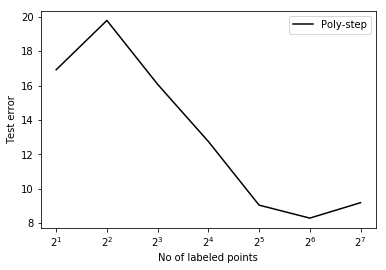

In [43]:
#nr_list, lin_mses, poly_mses, step_mses, poly_step_mses = get_results(5)

fig, ax = plt.subplots()
#ax.plot(nr_list, lin_mses, 'r', label='Linear')
#ax.plot(nr_list, poly_mses, 'g', label='Polynomial')
#ax.plot(nr_list, step_mses, 'b', label='Step')
ax.plot(nr_list, poly_step_mses, 'k', label='Poly-step')
ax.legend(loc='upper right')
plt.xticks(nr_list)
#plt.ylim(0, 0.6)
ax.set_xscale('log', basex=2)
ax.set(xlabel='No of labeled points', ylabel='Test error')
plt.savefig('usps_poly_step.png')
plt.show()